In [1]:
import numpy as np
import pandas as pd 
import cv2
from collections import Counter
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import seaborn as sns
import os
import shutil
from glob import glob
%matplotlib inline

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, Flatten, Dense, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.callbacks import ModelCheckpoint,ReduceLROnPlateau, EarlyStopping

from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
from tensorflow.keras.models import load_model
model = load_model('firstmodel')

In [5]:
artists = pd.read_csv('csv/artists.csv')

In [6]:
artists.head()

,id,name,years,genre,nationality,bio,wikipedia,paintings
0,0,Amedeo Modigliani,1884 - 1920,Expressionism,Italian,Amedeo Clemente Modigliani (Italian pronunciat...,http://en.wikipedia.org/wiki/Amedeo_Modigliani,193
1,1,Vasiliy Kandinskiy,1866 - 1944,"Expressionism,Abstractionism",Russian,Wassily Wassilyevich Kandinsky (Russian: Васи́...,http://en.wikipedia.org/wiki/Wassily_Kandinsky,88
2,2,Diego Rivera,1886 - 1957,"Social Realism,Muralism",Mexican,Diego María de la Concepción Juan Nepomuceno E...,http://en.wikipedia.org/wiki/Diego_Rivera,70
3,3,Claude Monet,1840 - 1926,Impressionism,French,Oscar-Claude Monet (; French: [klod mɔnɛ]; 14 ...,http://en.wikipedia.org/wiki/Claude_Monet,73
4,4,Rene Magritte,1898 - 1967,"Surrealism,Impressionism",Belgian,René François Ghislain Magritte (French: [ʁəne...,http://en.wikipedia.org/wiki/René_Magritte,194


In [7]:
# Sort artists by number of paintings
artists = artists.sort_values(by=['paintings'], ascending=False)

# Create a dataframe with artists having more than 200 paintings
artists_top = artists[artists['paintings'] >= 200].reset_index()
artists_top = artists_top[['name', 'paintings']]

artists_top['class_weight'] = artists_top.paintings.sum() / (artists_top.shape[0] * artists_top.paintings)
artists_top

,name,paintings,class_weight
0,Vincent van Gogh,877,0.445631
1,Edgar Degas,702,0.556721
2,Pablo Picasso,439,0.890246
3,Pierre-Auguste Renoir,336,1.163149
4,Albrecht Dürer,328,1.191519
5,Paul Gauguin,311,1.256650
6,Francisco Goya,291,1.343018
7,Rembrandt,262,1.491672
8,Alfred Sisley,259,1.508951
9,Titian,255,1.532620


In [8]:
updated_name = "Albrecht_Dürer".replace("_", " ")
artists_top.iloc[4, 0] = updated_name

In [9]:
artists_top

,name,paintings,class_weight
0,Vincent van Gogh,877,0.445631
1,Edgar Degas,702,0.556721
2,Pablo Picasso,439,0.890246
3,Pierre-Auguste Renoir,336,1.163149
4,Albrecht Dürer,328,1.191519
5,Paul Gauguin,311,1.256650
6,Francisco Goya,291,1.343018
7,Rembrandt,262,1.491672
8,Alfred Sisley,259,1.508951
9,Titian,255,1.532620


In [10]:
images_dir = 'dataset/training'
artists_dirs = os.listdir(images_dir)
artists_top_name = artists_top['name'].str.replace(' ', '_').values

# See if all directories exist
for name in artists_top_name:
    if os.path.exists(os.path.join(images_dir, name)):
        print("Found -->", os.path.join(images_dir, name))
    else:
        print("Did not find -->", os.path.join(images_dir, name))

Found --> dataset/training/Vincent_van_Gogh
Found --> dataset/training/Edgar_Degas
Found --> dataset/training/Pablo_Picasso
Found --> dataset/training/Pierre-Auguste_Renoir
Found --> dataset/training/Albrecht_Dürer
Found --> dataset/training/Paul_Gauguin
Found --> dataset/training/Francisco_Goya
Found --> dataset/training/Rembrandt
Found --> dataset/training/Alfred_Sisley
Found --> dataset/training/Titian
Found --> dataset/training/Marc_Chagall


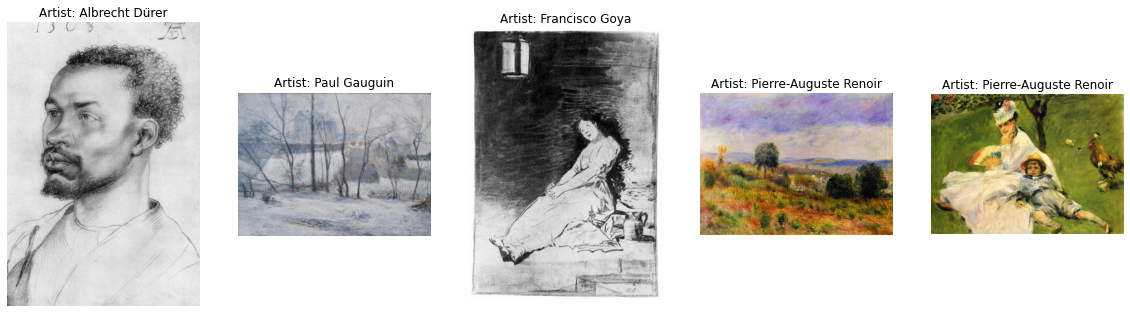

In [11]:
import random
n = 5
fig, axes = plt.subplots(1, n, figsize=(20,10))

for i in range(n):
    random_artist = random.choice(artists_top_name)
    random_image = random.choice(os.listdir(os.path.join(images_dir, random_artist)))
    random_image_file = os.path.join(images_dir, random_artist, random_image)
    image = plt.imread(random_image_file)
    axes[i].imshow(image)
    axes[i].set_title("Artist: " + random_artist.replace('_', ' '))
    axes[i].axis('off')

plt.show()

In [12]:
batch_size = 64
train_input_shape = (224, 224, 3)
n_classes = artists_top.shape[0]

train_datagen = ImageDataGenerator(validation_split=0.2,
                                   rescale=1./255.,
                                   #rotation_range=45,
                                   #width_shift_range=0.5,
                                   #height_shift_range=0.5,
                                   shear_range=5,
                                   #zoom_range=0.7,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                  )

train_generator = train_datagen.flow_from_directory(directory=images_dir,
                                                    class_mode='categorical',
                                                    target_size=train_input_shape[0:2],
                                                    batch_size=batch_size,
                                                    subset="training",
                                                    shuffle=True,
                                                    classes=artists_top_name.tolist()
                                                   )

valid_generator = train_datagen.flow_from_directory(directory=images_dir,
                                                    class_mode='categorical',
                                                    target_size=train_input_shape[0:2],
                                                    batch_size=batch_size,
                                                    subset="validation",
                                                    shuffle=True,
                                                    classes=artists_top_name.tolist()
                                                   )

Found 3444 images belonging to 11 classes.
Found 855 images belonging to 11 classes.


In [13]:
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size

In [13]:
from tensorflow.keras.applications import ResNet50
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=train_input_shape)

for layer in base_model.layers:
    layer.trainable = True

In [14]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [15]:
classifier = Flatten()(base_model.output)

#Initialize the CNN
classifier = Dense(512, activation='relu')(classifier)
classifier = BatchNormalization()(classifier)

classifier= Dense(16, activation='relu')(classifier)
classifier = BatchNormalization()(classifier)

output = Dense(11, activation = 'softmax')(classifier)

In [16]:
model = Model(inputs=base_model.input, outputs=output)

In [17]:
model.compile(optimizer = Adam(lr =0.0001), loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [18]:
n_epoch = 20

early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1, 
                           mode='auto', restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, 
                              verbose=1, mode='auto')

history = model.fit_generator(generator=train_generator, steps_per_epoch=STEP_SIZE_TRAIN,
                              validation_data=valid_generator, validation_steps=STEP_SIZE_VALID,
                              epochs=n_epoch,
                              shuffle=True,
                              verbose=1,
                              callbacks=[reduce_lr,early_stop]
                             )

In [ ]:
for layer in model.layers:
    layer.trainable = False

for layer in model.layers[:50]:
    layer.trainable = True

optimizer = Adam(lr=0.0001)

model.compile(loss='categorical_crossentropy',
              optimizer=optimizer, 
              metrics=['accuracy'])

n_epoch = 100
history2 = model.fit(train_generator, steps_per_epoch=STEP_SIZE_TRAIN,
                              validation_data=valid_generator, validation_steps=STEP_SIZE_VALID,
                              epochs=n_epoch,
                              shuffle=True,
                              verbose=1,
                              callbacks=[reduce_lr, early_stop])

Epoch 1/100


In [29]:
train_generator.class_indices

{'Vincent_van_Gogh': 0,
 'Edgar_Degas': 1,
 'Pablo_Picasso': 2,
 'Pierre-Auguste_Renoir': 3,
 'Albrecht_Dürer': 4,
 'Paul_Gauguin': 5,
 'Francisco_Goya': 6,
 'Rembrandt': 7,
 'Alfred_Sisley': 8,
 'Titian': 9,
 'Marc_Chagall': 10}

# prediction

In [1]:
from tensorflow.keras.models import load_model
import numpy as np

In [2]:
model=load_model('freezed2')

In [6]:
from PIL import Image
test_image = Image.open('dataset/training/Alfred_Sisley/Alfred_Sisley_1.jpg') 
test_image = test_image.resize([224,224])

test_image = np.array(test_image).reshape(224,224,3)
test_image = test_image / 255.0
test_image = np.expand_dims(test_image, axis=0)

prediction = model.predict(test_image)

ValueError: in user code:

    /home/binu/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1478 predict_function  *
        return step_function(self, iterator)
    /home/binu/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1468 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /home/binu/anaconda3/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/binu/anaconda3/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/binu/anaconda3/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/binu/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1461 run_step  **
        outputs = model.predict_step(data)
    /home/binu/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1434 predict_step
        return self(x, training=False)
    /home/binu/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:998 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /home/binu/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/input_spec.py:271 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) +

    ValueError: Input 0 is incompatible with layer model_8: expected shape=(None, 3, 224, 224), found shape=(None, 224, 224, 3)


In [35]:
from tensorflow.keras.preprocessing import image
from tensorflow.python.framework.ops import disable_eager_execution

disable_eager_execution()

test_image = image.load_img('dataset/training/Alfred_Sisley/Alfred_Sisley_1.jpg', target_size=([224,224]))

test_image = image.img_to_array(test_image)
test_image /= 255.
test_image = np.expand_dims(test_image, axis=1)

prediction = model.predict(test_image)
prediction_probability = np.amax(prediction)
prediction_idx = np.argmax(prediction)


ValueError: Calling `Model.predict` in graph mode is not supported when the `Model` instance was constructed with eager mode enabled. Please construct your `Model` instance in graph mode or call `Model.predict` with eager mode enabled.

In [ ]:
tf.

In [7]:
import cv2
img = cv2.imread('dataset/training/Alfred_Sisley/Alfred_Sisley_1.jpg')
img = cv2.resize(img,(224,224))     # resize image to match model's expected sizing
img = img.reshape(1,224,224,3) # return the image with shaping that TF wants.
prediction = model.predict(img)
prediction

InvalidArgumentError:  Default MaxPoolingOp only supports NHWC on device type CPU
	 [[node model_8/pool1_pool/MaxPool (defined at <ipython-input-7-4791d67cf9fe>:5) ]] [Op:__inference_predict_function_42191]

Function call stack:
predict_function


In [18]:
from tensorflow.compat.v1 import placeholder,transpose
from tensorflow.python.framework.ops import disable_eager_execution

disable_eager_execution()

In [20]:
images_nhwc = placeholder(tf.float32, [None, 200, 300, 3])  # input batch
out = transpose(images_nhwc, [0, 3, 1, 2])
print(out.get_shape())


(None, 3, 200, 300)


In [27]:
from PIL import Image
test_image = Image.open('dataset/training/Alfred_Sisley/Alfred_Sisley_1.jpg') 
test_image = test_image.resize([224,224])


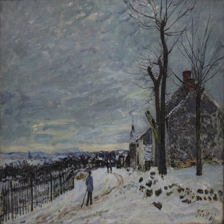

In [28]:
test_image